# HW 7 - Correlation Maps

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import cartopy.crs as ccrs
import scipy.stats as stats

In [2]:
df=pd.read_csv('./nino34_1870_2020.txt', delimiter="\t", header=None)

# replace invalid values with NaN 
df=df.replace(-99.99,np.nan)
# convert dataframe to numpy matrix
data=df.values

#extract July 
year=data[:,0]
nino34=data[:,7]

tr=(1948,2021)

tind=((year>=tr[0])&(year<tr[1]))
year_sel=year[tind]
nino34_sel=nino34[tind]
nino34_sel

array([27.16, 26.84, 26.14, 27.88, 26.63, 27.42, 26.2 , 25.91, 26.28,
       27.91, 27.26, 26.95, 26.98, 26.9 , 26.92, 27.95, 26.58, 28.03,
       27.45, 27.12, 27.54, 27.32, 26.25, 26.59, 28.06, 26.08, 26.58,
       25.99, 27.38, 27.67, 26.75, 27.02, 27.25, 26.79, 27.86, 27.11,
       26.82, 26.62, 27.38, 28.56, 25.69, 26.76, 27.37, 27.84, 27.5 ,
       27.55, 27.38, 27.26, 27.08, 28.83, 26.49, 26.39, 26.65, 27.24,
       27.8 , 27.37, 27.64, 27.22, 27.25, 26.86, 27.19, 27.91, 26.34,
       27.  , 27.66, 26.94, 27.36, 28.78, 26.97, 27.44, 27.49, 27.64,
       27.18])

In [3]:

# load netcdf data
fn='./air.mon.mean.nc'
ds=xr.open_dataset(fn)
# select time range
TMP=ds.air.sel(time=slice("1948-01-01","2020-12-31"))
# July temperature
mon=7;
TMP_month=TMP.sel(time=TMP['time.month']==mon)
TMP_month

<xarray.DataArray 'air' (time: 73, lat: 73, lon: 144)>
[767376 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-07-01 1949-07-01 ... 2020-07-01
Attributes:
    long_name:     Monthly Mean Air Temperature at sigma level 0.995
    valid_range:   [-2000.  2000.]
    units:         degC
    precision:     1
    var_desc:      Air Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Obs
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [-73.78001  42.14595]

In [4]:
da=TMP_month
nlon=da.lon.size
nlat=da.lat.size
def regrcorr2(X,Y,CL):
    C=np.cov(X,Y)
     # slope
    a=np.empty(2)
    a[0]=C[0,1]/C[0,0]
     # intercept
    a[1]=np.mean(Y)-a[0]*np.mean(X)
     # correlation coefficient
    r=C[0,1]/np.sqrt(C[0,0]*C[1,1]) 
     # sample size
    N=np.size(Y) 
     # lag-1 autocorrelation for Y
    y0=Y[0:-1]
    y1=Y[1:]
    Cy=np.cov(y0,y1)
    r1=Cy[0,1]/np.sqrt(Cy[0,0]*Cy[1,1])
    #lag auto corr for x
    x0=X[0:-1]
    x1=X[1:]
    Cx=np.cov(x0,x1)
    r2=Cx[0,1]/np.sqrt(Cy[0,0]*Cx[1,1])
     # effective sample size
    Neff=N*(1-r1)/(1+r1)
    Neff=min(N,Neff)
     # SE of regression
    Y_pred=a[0]*X+a[1]
    err2=sum(np.square(Y-Y_pred))/(Neff-2)
    SE2=err2/sum(np.square(X-np.mean(X)))
    SE=np.sqrt(SE2)
     # calculate tcrit (two-tailed)
    tcrit=stats.t.ppf((1+CL)/2,Neff-2)
    CI=tcrit*SE
    return a,r,CI

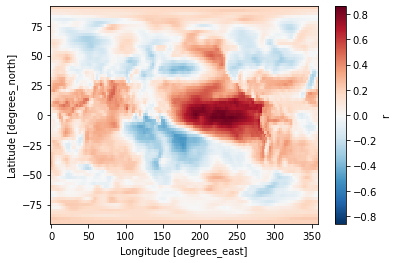

In [5]:
# calculate correlation coefficient
r_mat=np.empty((nlat,nlon))
slope=np.empty((nlat,nlon))
confint=np.empty((nlat,nlon))
# r_mat[:]=np.nan
y=nino34_sel

# CL
CL=0.99
for ii in np.arange(0,nlon):
    for jj in np.arange(0,nlat):
        x=TMP_month.isel(lat=jj,lon=ii).values
        a,r,CI=regrcorr2(x,y,CL)
#         r=np.corrcoef(x,y)
        r_mat[jj,ii]=r
        slope[jj,ii]=a[0]
        confint[jj,ii]=CI

# re-assemble the data array and save it as netcdf
da=xr.DataArray(data=r_mat,dims=['lat','lon'],coords=dict(lat=TMP.lat,lon=TMP.lon),name='r')

# save the data to netcdf
ds_out=da.to_dataset()
ds_out.to_netcdf('./ncep_nino34_r.nc')

# make a simple plot

da.plot()
plt.show()

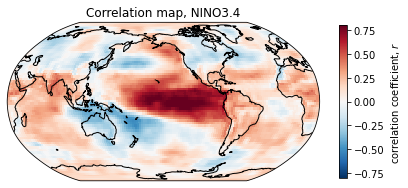

In [6]:
X=da.lon.values
Y=da.lat.values
Z=da.values

# grid boundaries
Xb=np.arange(-2.5/2, 360,2.5)
Yb=np.arange(90-2.5/2, -90,-2.5)
Yb=np.append(90,Yb)
Yb=np.append(Yb,-90)


fig=plt.figure(figsize=(7, 4))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-150))
ax.coastlines()
cf=plt.pcolormesh(Xb,Yb,Z, transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-0.8,vmax=0.8,rasterized=True)
fig.colorbar(cf, ax=ax,shrink=0.7, label='correlation coefficient, $\itr$')
ax.set_title('Correlation map, NINO3.4')

fn='Fig_ncep_nino34_correlation_plot'
plt.savefig('./fig/'+fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig('./fig/'+fn+'.png',bbox_inches="tight",dpi=300)
plt.show()

In [16]:
def regrcorr3(X,Y,CL):
    C=np.cov(X,Y)
    # slope
    a=np.empty(2)
    a[0]=C[0,1]/C[0,0]
    # intercept
    a[1]=np.mean(Y)-a[0]*np.mean(X)
    # correlation coefficient
    r=C[0,1]/np.sqrt(C[0,0]*C[1,1])    
    # sample size
    N=np.size(Y)    
    # lag-1 autocorrelation for Y
    y0=Y[0:-1]
    y1=Y[1:]
    Cy=np.cov(y0,y1)
    r1=Cy[0,1]/np.sqrt(Cy[0,0]*Cy[1,1])
    # effective sample size
    Neff=N*(1-r1)/(1+r1)
    Neff=min(N,Neff)
    # SE of regression
    Y_pred=a[0]*X+a[1]
    err2=sum(np.square(Y-Y_pred))/(Neff-2)
    SE2=err2/sum(np.square(X-np.mean(X)))
    SE=np.sqrt(SE2)
    # calculate tcrit (two-tailed)
    tcrit=stats.t.ppf((1+CL)/2,Neff-2)
    CI=tcrit*SE
    return a,r,CI,Neff

In [21]:
slope=np.empty((nlat,nlon))
r_mat=np.empty((nlat,nlon))
confint=np.empty((nlat,nlon))
Neff_mat=np.empty((nlat,nlon))

xx=TMP_month.values
CL=0.95

for ii in np.arange(0,nlon):
    for jj in np.arange(0,nlat):
        xx=TMP_month.isel(lat=jj,lon=ii).values
        a,r,CI,Neff=regrcorr3(xx,yy,CL)
        slope[jj,ii]=a[0]
        r_mat[jj,ii]=r
        confint[jj,ii]=CI
        Neff_mat[jj,ii]=Neff

In [23]:
trdsig=np.zeros((nlat,nlon))
trdsig[confint<np.abs(slope)]=1

In [11]:
da1=xr.DataArray(data=r_mat,dims=['lat','lon'],coords=dict(lat=TMP_month.lat,lon=TMP_month.lon),name='r')
da2=xr.DataArray(data=slope,dims=['lat','lon'],coords=dict(lat=TMP_month.lat,lon=TMP_month.lon),name='slope')
da3=xr.DataArray(data=confint,dims=['lat','lon'],coords=dict(lat=TMP_month.lat,lon=TMP_month.lon),name='CI')
da4=xr.DataArray(data=Neff_mat,dims=['lat','lon'],coords=dict(lat=TMP_month.lat,lon=TMP_month.lon),name='Neff')
da5=xr.DataArray(data=trdsig,dims=['lat','lon'],coords=dict(lat=TMP_month.lat,lon=TMP_month.lon),name='trdsig')

# optional: merge data arrays into a new dataset and save it in netcdf format 
ds_out=xr.merge([da1,da2,da3,da4,da5])
ds_out.to_netcdf('./ncep_r_slope_sig.nc')
ds_out

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    r        (lat, lon) float64 7.094e-312 7.093e-312 0.2028 ... 0.03484 0.03484
    slope    (lat, lon) float64 7.094e-312 7.093e-312 2.122e-314 ... 0.0 0.0 0.0
    CI       (lat, lon) float64 7.094e-312 7.093e-312 0.0 0.0 ... 0.0 0.0 0.0
    Neff     (lat, lon) float64 7.094e-312 7.093e-312 0.3506 ... 0.05419 0.05419
    trdsig   (lat, lon) float64 0.0 0.0 1.0 0.0 1.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

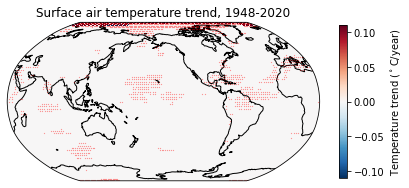

In [27]:
#plot global temperature trend map
X=da2.lon.values
Y=da2.lat.values
Z=da2.values

X_mat,Y_mat=np.meshgrid(X,Y)
ind_plot=(trdsig==1)

# grid boundaries
Xb=np.arange(-2.5/2, 360,2.5)
Yb=np.arange(90-2.5/2, -90,-2.5)
Yb=np.append(90,Yb)
Yb=np.append(Yb,-90)

fig=plt.figure(figsize=(7, 4))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-150))
ax.coastlines()
cf=ax.pcolormesh(Xb,Yb,Z, transform=ccrs.PlateCarree(),vmin=-0.11,vmax=0.11,cmap='RdBu_r',rasterized=True)
plt.colorbar(cf, ax=ax,shrink=0.7, label='Temperature trend ($^\circ$C/year)')

plt.plot(X_mat[ind_plot],Y_mat[ind_plot], '.',color='red',markersize=0.3, transform=ccrs.PlateCarree())

ax.set_title('Surface air temperature trend, 1948-2020')

fn='Fig_global_annual_trend_Robinson_sig'
plt.savefig('./fig/'+fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig('./fig/'+fn+'.png',bbox_inches="tight",dpi=300)
plt.show()